In [1]:
import veloagent
import anndata
import torch
import scvelo as scv
import scanpy as sc

Global seed set to 0


## Load AnnData

In [2]:
adata = anndata.read_h5ad('/Users/brentyoon/Documents/COMP402/code/data/chicken.h5ad')

## Preprocessing Dataset

In [5]:
veloagent.preprocess(adata)

/Users/brentyoon/opt/anaconda3/envs/norm/lib/python3.8/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


## VAE Embedding

In [9]:
vae, optimizer, loss_fn = veloagent.get_vae(adata, z_dim=10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae.to(device)
global_nb_indices = adata.uns['neighbors']['indices']

In [ ]:
best_model = veloagent.train_vae(adata, vae, optimizer, loss_fn, global_nb_indices, patience=25, num_epochs=500, batch=0.25)

 37%|█████████▉                 | 183/500 [01:48<02:40,  1.98it/s, loss=1.39e+7]

In [ ]:
vae.load_state_dict(best_model)
veloagent.get_embedding(adata, vae, device)

## Gene-Gene Deep Neural Network

In [ ]:
paths = veloagent.load_protein_paths(species="chicken", base="/Users/brentyoon/Documents/COMP402/code/dataset/conn_mat")
protein_names_path = paths[0]
protein_alias_path = paths[1]
gene_conn_path = paths[2]

In [ ]:
# Creating gene-gene interaction prior layer
conn_mat = veloagent.create_con_mat(adata, adata.n_vars, protein_names_path, protein_alias_path, gene_conn_path, varname='index')

In [ ]:
genenet = veloagent.GeneNet(in_dim=adata.obsm['cell_embed'][0].shape[0], gene_dim=adata.n_vars, conn=conn_mat)
optimizer = torch.optim.Adam(genenet.parameters(), lr=0.0001, weight_decay=0.00001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
genenet.to(device)

In [ ]:
veloagent.train_gg(num_epochs=500, data=adata, embed_basis='cell_embed', genenet=genenet, device=device, optimizer=optimizer, patience=10, num_nbrs=30, dt=0.5, batch=0.25)

In [ ]:
veloagent.train_nbr(num_epochs=50, data=adata, embed_basis='cell_embed', genenet=genenet, device=device, optimizer=optimizer, num_nbrs=5, dt=0.5, batch=0.25)

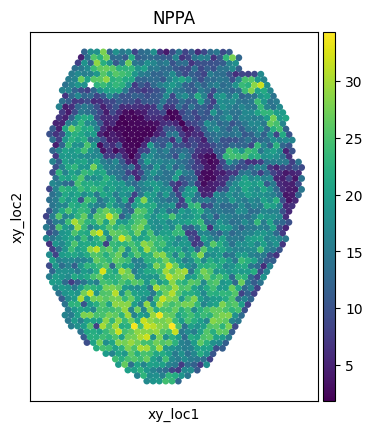

In [4]:
import matplotlib.pyplot as plt
sc.pl.spatial(adata, color='NPPA', layer='Ms', color_map='viridis', library_id=None, scale_factor=0.5, basis='xy_loc', spot_size=300, show=False)
plt.gca().invert_yaxis()
plt.show()

In [ ]:
sc.pl.spatial(adata, color='NPPA', layer='velocity', color_map='viridis', library_id=None, scale_factor=0.5, basis='xy_loc', spot_size=300, show=False)
plt.gca().invert_yaxis()
plt.show()

## Velocity Projection on UMAP

In [ ]:
scv.tl.velocity_graph(adata, vkey='velocity')
scv.pl.velocity_embedding_stream(adata,
                                legend_loc="right margin", 
                                vkey='velocity', 
                                basis='umap', 
                                color=['scc_anno'],
                                palette="tab20",
                                dpi=150)

## Agent-Based Modeling

In [ ]:
# rescaling the coordinates
adata.obs['x_loc'] = adata.obsm['spatial'].T[0]/20  #5
adata.obs['y_loc'] = adata.obsm['spatial'].T[1]/20  #5
adata.obs['x_loc'] = adata.obs.x_loc.astype(int)
adata.obs['y_loc'] = adata.obs.y_loc.astype(int)
adata.obs['x_loc'] = adata.obs['x_loc'] - min(adata.obs['x_loc'])
adata.obs['y_loc'] = adata.obs['y_loc'] - min(adata.obs['y_loc'])

In [ ]:
abm = veloagent.CellModel(adata, steps=100, freedom=2, nbr_radius=50, sig_ratio=0.7) #30

In [ ]:
abm.step()

In [ ]:
adata.write_h5ad("chicken.h5ad")

## Velocity Projection on Spatial Map

In [ ]:
scv.tl.velocity_graph(adata, vkey='velocity')
scv.pl.velocity_embedding_stream(adata,
                                legend_loc="right margin", 
                                vkey='velocity', 
                                basis='spatial', 
                                color=['scc_anno'],
                                palette="tab20",
                                dpi=150)